In [1]:
import pandas as pd
from pathlib import Path
import re
import numpy as np
import json
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from sklearn.decomposition import PCA
import numpy as np

In [2]:
timesteps = 10
window_size = 44
window_overlap = 0.5
conversion_constant = (2.0*16.0)/8192
folder = Path("TCC_data/processed_dataset/labeled_dataset_downsample_200_filter")

In [ ]:
print("test")

In [3]:
def extract_class(filename):
    match = re.search(r'benchy_\d+_(.*?)\.parquet\.gzip', filename)
    if match:
        return match.group(1)
    return None

In [4]:
def window_using_rolling(df,window=44,step=22,columns=["accel_x","accel_y","accel_z"]):
    for column in set(columns):
        df[column] = df[column]*conversion_constant
    rolling = df[columns].rolling(window=window,step=step)
    return np.array(list(rolling)[2:])

In [9]:
def image_extraction(dataset):
    p_data = np.empty((0,*dataset.shape[1:]))

    for sample in tqdm(dataset):
        # Perform 2D Discrete Fourier Transform (DFT)
        dft_image = np.fft.fft2(sample)

        # Compute the magnitude spectrum (for visualization)
        magnitude_spectrum = np.log10(np.abs(dft_image)+1)
        p_data = np.vstack((p_data,np.reshape(magnitude_spectrum,(1,*magnitude_spectrum.shape))
    ))

    return p_data

In [6]:
def feature_extraction(dataset,label):
    p_data = np.empty((0,9))

    for sample in dataset:
        pca = PCA(n_components=1)
        pca.fit(sample)
        data = np.hstack([np.mean(sample,axis=0), np.std(sample,axis=0), pca.components_[0]])
        p_data = np.vstack((p_data,data))

    label_column = np.ones((p_data.shape[0], 1))*label
    p_data = np.hstack((p_data,label_column))
    return p_data

In [7]:
df_all = pd.DataFrame()
list_classes = set()
for file in folder.glob("benchy_*"):
    list_classes.add(extract_class(file.name))
print(list_classes)

class_index = {'healthy':0, 'temp_220':1, 'temp_230':2, 'nozzle_03':3,'nozzle_02':4, 'loose_head':5}
print(class_index)
with open(folder/"class_index.json", 'w') as json_file:
    json.dump(class_index, json_file)

{'healthy', 'nozzle_03', 'loose_head', 'temp_220', 'nozzle_02', 'temp_230'}
{'healthy': 0, 'temp_220': 1, 'temp_230': 2, 'nozzle_03': 3, 'nozzle_02': 4, 'loose_head': 5}


# Image dataset data

In [10]:
x_data = np.empty((0, timesteps, window_size, 4))
y_data = np.empty((0, 1))

for file in folder.glob("benchy_1_*"):
    df = pd.read_parquet(file)
    data = window_using_rolling(df, window=window_size, step=int(window_size*window_overlap), columns=["accel_x", "accel_y", "accel_z", "accel_x"])
    unique = df["class"].unique()
    if len(unique) != 1:
        print(f"failure: {file} - {unique}")
        break
    else:
        unique = unique[0]
    
    processed_data = image_extraction(data)

100%|██████████| 46133/46133 [03:37<00:00, 211.70it/s] 


In [15]:
data.shape

(46133, 44, 4)

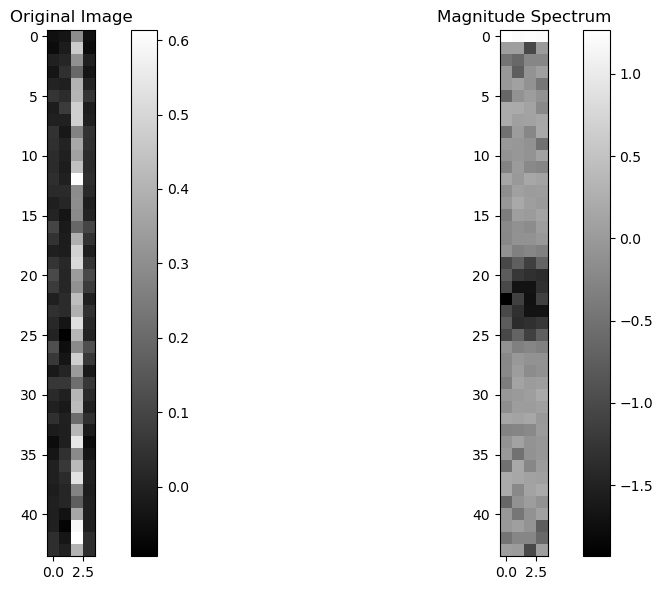

In [19]:
import matplotlib.pyplot as plt
# Perform 2D Discrete Fourier Transform (DFT)
image = data[10000]
dft_image = np.fft.fft2(image)

# Shift the zero-frequency component to the center of the spectrum
# dft_shifted = np.fft.fftshift(dft_image)

# Compute the magnitude spectrum (for visualization)
magnitude_spectrum = np.log10(np.abs(dft_image))

# Plot the original image and its magnitude spectrum
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.colorbar()

# Magnitude Spectrum
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')  # Use log scale for better visualization
plt.title('Magnitude Spectrum')
plt.colorbar()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [36]:
x_data = np.empty((0, timesteps, window_size, 4))
y_data = np.empty((0, 1))

def process_file(file):
    df = pd.read_parquet(file)
    data = window_using_rolling(df, window=window_size, step=int(window_size*window_overlap), columns=["accel_x", "accel_y", "accel_z", "accel_x"])
    unique = df["class"].unique()
    if len(unique) != 1:
        print(f"failure: {file} - {unique}")
        return None
    else:
        unique = unique[0]
    
    processed_data = image_extraction(data)
    processed_data2 = processed_data[processed_data.shape[0] % timesteps:, :]
    reshaped_data = processed_data2.reshape((
        processed_data2.shape[0] // timesteps,
        timesteps,
        *processed_data2.shape[1:],
    ))
    y_data_temp = np.ones((reshaped_data.shape[0], 1)) * class_index[unique]
    return reshaped_data, y_data_temp

def collect_results(result):
    global x_data, y_data
    if result is not None:
        reshaped_data, y_data_temp = result
        x_data = np.vstack((x_data, reshaped_data))
        y_data = np.vstack((y_data, y_data_temp))

with Pool(1) as pool:
    files = list(folder.glob("benchy_*"))[:1]
    for result in tqdm(pool.imap_unordered(process_file, files), total=len(files)):
        collect_results(result)

  0%|          | 0/1 [03:32<?, ?it/s]:36, 33.15it/s] 


KeyboardInterrupt: 

In [ ]:
np.save(folder/"processed_labeled_image_data",x_data,fix_imports=False)
np.save(folder/"processed_labeled_image_result",y_data,fix_imports=False)

# Feature Dataset

Normalize data

In [8]:
accel_x = np.array([])
accel_y = np.array([])
accel_z = np.array([])
counter = dict()
x_size = []
x_value = []
y_size = []
y_value = []
z_size = []
z_value = []

for file in tqdm(list(folder.glob("benchy_*"))):
    file_class = extract_class(file.name)
    df = pd.read_parquet(file)
    accel_x = np.concatenate([accel_x,df["accel_x"]*conversion_constant])
    accel_y = np.concatenate([accel_y,df["accel_y"]*conversion_constant])
    accel_z = np.concatenate([accel_z,df["accel_z"]*conversion_constant])

mean_accel_x = np.mean(accel_x)
mean_accel_y = np.mean(accel_y)
mean_accel_z = np.mean(accel_z)

std_accel_x = np.std(accel_x)
std_accel_y = np.std(accel_y)
std_accel_z = np.std(accel_z)

 46%|████▋     | 13/28 [00:22<00:57,  3.83s/it]

: 

In [ ]:
timesteps = 10
x_data = np.empty((0, timesteps, 9))
y_data = np.empty((0, 1))

def process_file(file):
    df = pd.read_parquet(file)
    
    # Normalize accelerometer data
    df["accel_x"] = (df["accel_x"] * conversion_constant - mean_accel_x) / std_accel_x
    df["accel_y"] = (df["accel_y"] * conversion_constant - mean_accel_y) / std_accel_y
    df["accel_z"] = (df["accel_z"] * conversion_constant - mean_accel_z) / std_accel_z

    # Apply rolling window function
    data = window_using_rolling(df)
    
    unique = df["class"].unique()
    if len(unique) != 1:
        print(f"failure: {file} - {unique}")
        return None, None
    unique = unique[0]

    # Feature extraction
    processed_data = feature_extraction(data, class_index[unique])

    # Reshape the data
    processed_data2 = processed_data[processed_data.shape[0] % timesteps:, :-1]
    reshaped_data = processed_data2.reshape((
        processed_data2.shape[0] // timesteps,
        timesteps,
        *processed_data2.shape[1:],
    ))

    return reshaped_data, np.ones((reshaped_data.shape[0], 1)) * class_index[unique]

def collect_results(result):
    global x_data, y_data
    if result is not None:
        reshaped_data, y_data_temp = result
        x_data = np.vstack((x_data, reshaped_data))
        y_data = np.vstack((y_data, y_data_temp))

# Create a pool of workers equal to the number of CPU cores
with Pool(cpu_count()) as pool:
    files = list(folder.glob("benchy_*"))
    futures = [pool.apply_async(process_file, (file,)) for file in files]
    
    for future in tqdm(futures):
        result = future.get()
        collect_results(result)

In [ ]:
np.save(folder/"processed_labeled_normalized_data",x_data,fix_imports=False)
np.save(folder/"processed_labeled_normalized_result",y_data,fix_imports=False)